In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

import numpy as np

## SincConv (fast implementation)

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

import numpy as np

class SincConvFast(Layer):


    @staticmethod
    def hz_to_mel(hz):
        return 2595.0 * np.log10(1.0 + hz / 700.0)

    @staticmethod
    def mel_to_hz(mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def __init__(self, nb_filters, kernel_size, sample_freq,
                 stride=1, padding="VALID", min_low_hz=50, min_band_hz=50,
                 **kwargs):
        super(SincConvFast, self).__init__(**kwargs)

        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.sample_freq = sample_freq
        self.stride = stride
        self.padding = padding
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # Force filter size to be odd for later optimizations with symmetry
        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size + 1

        # Set trainable parameters
        self.low_hz = self.add_weight(
            name='low_hz',
            shape=(self.nb_filters,),
            initializer="zeros",
            trainable=True)
        self.band_hz = self.add_weight(
            name='band_hz',
            shape=(self.nb_filters,),
            initializer="zeros",
            trainable=True)

        # Initialize weights with frequencies of the mel-scale filter-bank
        low_freq_mel = self.hz_to_mel(30)
        high_freq_mel = self.hz_to_mel(self.sample_freq / 2 - (self.min_low_hz + self.min_band_hz))
        mel_points = np.linspace(low_freq_mel, high_freq_mel, num=self.nb_filters + 1)
        hz_points = self.mel_to_hz(mel_points)
        self.set_weights([hz_points[:-1], np.diff(hz_points)])

        # Determine half of t
        t_linspace = np.arange(-(self.kernel_size - 1) / 2, 0)
        t = tf.Variable(2 * np.pi * t_linspace / self.sample_freq)
        t = tf.cast(t, "float32")
        self.t = tf.reshape(t, (1, -1))

        # Determine half of the hamming window
        n = np.linspace(0, (self.kernel_size / 2) - 1, num=int((self.kernel_size / 2)))
        window = 0.54 - 0.46 * tf.cos(2 * np.pi * n / self.kernel_size)
        window = tf.cast(window, "float32")
        self.window = tf.Variable(window)

    def call(self, X):
        low = self.min_low_hz + tf.abs(self.low_hz)
        high = tf.clip_by_value(low + self.min_band_hz + tf.abs(self.band_hz), self.min_low_hz, self.sample_freq / 2)
        band = high - low

        low_times_t = tf.linalg.matmul(tf.reshape(low, (-1, 1)), self.t)
        high_times_t = tf.linalg.matmul(tf.reshape(high, (-1, 1)), self.t)

        band_pass_left = ((tf.sin(high_times_t) - tf.sin(low_times_t)) / (self.t / 2)) * self.window
        band_pass_center = tf.reshape(2 * band, (-1, 1))
        band_pass_right = tf.reverse(band_pass_left, [1])

        filters = tf.concat([band_pass_left,
                             band_pass_center,
                             band_pass_right], axis=1)
        filters = filters / (2 * band[:, None])

        # TF convolution assumes data is stored as NWC
        filters = tf.transpose(filters)
        filters = tf.reshape(filters, (self.kernel_size, 1, self.nb_filters))

        return tf.nn.conv1d(X, filters, self.stride, self.padding)

    def compute_output_shape(self, input_shape):
        out_width_size = conv_utils.conv_output_length(
            input_shape[1],
            self.kernel_size,
            padding="valid",
            stride=1,
            dilation=1)
        return (input_shape[0], out_width_size, self.nb_filters)


X = np.arange(63, dtype=np.single).reshape((1, 63, 1))
sinc_layer = SincConvFast(2, 9, 400)
y = sinc_layer(X)

print(y.numpy().transpose(0, 2, 1))

[[[-0.07339407 -0.09174239 -0.11009078 -0.1284394  -0.146788
   -0.16513652 -0.18348466 -0.20183328 -0.22018176 -0.2385304
   -0.25687903 -0.27522764 -0.2935753  -0.3119238  -0.33027256
   -0.348621   -0.36696953 -0.38531828 -0.4036668  -0.42201528
   -0.44036403 -0.4587125  -0.477061   -0.49540973 -0.5137573
   -0.53210604 -0.55045456 -0.5688031  -0.5871528  -0.6054994
   -0.623848   -0.64219654 -0.66054505 -0.67889357 -0.6972421
   -0.7155911  -0.73394006 -0.75228804 -0.770636   -0.788985
   -0.8073345  -0.8256806  -0.84403056 -0.86237764 -0.8807266
   -0.89907515 -0.917425   -0.9357721  -0.95412105 -0.97246903
   -0.9908171  -1.0091665  -1.0275155  -1.0458635  -1.0642116 ]
  [-0.18435074 -0.23043844 -0.27652615 -0.3226139  -0.36870134
   -0.41478932 -0.46087682 -0.50696474 -0.55305207 -0.59913963
   -0.64522773 -0.6913156  -0.737403   -0.7834905  -0.8295781
   -0.8756664  -0.92175376 -0.96784145 -1.013929   -1.0600163
   -1.1061046  -1.1521919  -1.1982797  -1.2443671  -1.2904555
   

## Load dataset (LibriSpeech)

**The following preprocessing steps (described in the original article) are not implemented:**

- Non-speech intervals at the beginning and end of each sentence were removed
- The Librispeech sentences with internal silences lasting more than 125 ms were split into multiple chunks.
- For the Librispeech corpus, the training and test material have been randomly selected to exploit 12-15 seconds of training material for each speaker and test sentences lasting 2-6 seconds.

In [3]:
sample_frequency = 16000 # 16kHz (LibriSpeech)
frame_size = 0.300       # 300ms
frame_stride = 0.01      # 10ms
max_num_frames = 100

frame_length = int(round(frame_size * sample_frequency))
frame_step = int(round(frame_stride * sample_frequency))

batch_size = 128
nb_speakers = 16

print("Input length: {} ({}s)".format(frame_length, frame_size * max_num_frames))
print("Input shape: {}".format((batch_size, frame_length)))

Input length: 4800 (30.0s)
Input shape: (128, 4800)


#### Download LibriSpeech

In [4]:
!wget https://www.openslr.org/resources/12/train-clean-100.tar.gz
!tar xf train-clean-100.tar.gz

--2024-04-09 16:18:44--  https://www.openslr.org/resources/12/train-clean-100.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://openslr.elda.org/resources/12/train-clean-100.tar.gz [following]
--2024-04-09 16:18:45--  https://openslr.elda.org/resources/12/train-clean-100.tar.gz
Resolving openslr.elda.org (openslr.elda.org)... 141.94.109.138, 2001:41d0:203:ad8a::
Connecting to openslr.elda.org (openslr.elda.org)|141.94.109.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6387309499 (5.9G) [application/x-gzip]
Saving to: ‘train-clean-100.tar.gz’

train-clean-100.tar 100%[===================>]   5.95G  12.7MB/s    in 8m 17s  

2024-04-09 16:27:04 (12.3 MB/s) - ‘train-clean-100.tar.gz’ saved [6387309499/6387309499]



In [5]:
from IPython.display import Audio
Audio('LibriSpeech/train-clean-100/1081/128618/1081-128618-0012.flac')

#### Create LibriSpeech generator

In [6]:
from keras.utils import Sequence
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import soundfile as sf
import glob

def get_frames_indices(filename):
    signal, fs = sf.read(filename)

    # Determine number of frames
    signal_length = len(signal)
    assert signal_length > frame_length
    num_frames = int(np.floor((signal_length - frame_length) / frame_step))

    # Limit the number of frames
    num_frames = min(num_frames, max_num_frames)

    return np.arange(0, num_frames * frame_step, frame_step)

def load_dataset(data_folder, max_speakers=10, max_utterances=10):
    X = []
    y = []

    files = glob.glob(data_folder)
    for speaker_id in range(min(max_speakers, len(files))):
        speaker_files = glob.glob(files[speaker_id] + '/*')

        nb_utterances_for_speaker = 0

        for sentence_id in range(len(speaker_files)):
            sentence_files = glob.glob(speaker_files[sentence_id] + '/*.flac')

            for utterance_id in range(len(sentence_files)):
                if nb_utterances_for_speaker >= max_utterances:
                    break

                filename = sentence_files[utterance_id]
                frames = get_frames_indices(filename)

                for frame in frames:
                    X.append([filename, frame])
                    y.append(speaker_id)

                nb_utterances_for_speaker += 1

    return X, y

class LibrispeechGenerator(Sequence) :

    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        nb_batches = len(self.y) / float(self.batch_size)
        return np.ceil(nb_batches).astype(int)

    def __getitem__(self, batch_id):
        X_batch = np.zeros((self.batch_size, frame_length, 1))
        y_batch = np.zeros(self.batch_size)

        for i in range(self.batch_size):
            id = batch_id * self.batch_size + i
            if id >= len(self.y):
                id = np.random.randint(0, len(self.y))

            path, frame = self.X[id]
            signal, fs = sf.read(path)

            X_batch[i, :, 0] = signal[frame:frame+frame_length]
            y_batch[i] = self.y[id]

        return X_batch, y_batch

In [7]:
# Load and determine audio filenames and their associated speaker
X_, y_ = load_dataset("LibriSpeech/train-clean-100/*",
                    max_speakers=nb_speakers,
                    max_utterances=8)

# Split in train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2)

# Instantiate custom generator to load each batch at once
train_gen = LibrispeechGenerator(X_train, y_train, batch_size)
val_gen = LibrispeechGenerator(X_val, y_val, batch_size)

In [8]:
print("Number of training batches:", len(train_gen))
print("Number of validation batches:", len(val_gen))

Number of training batches: 80
Number of validation batches: 20


## SincNet

**The model is simplified to avoid overfitting on our subset of LibriSpeech:**

- No LayerNormalization on the input as it prevents the model to converge
- The number of filters is reduced
- 2 conv layers instead of 3
- 2 dense layers instead of 3

### Create model

In [9]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, BatchNormalization, LeakyReLU, Flatten, LayerNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
def create_sincnet(enable_sincconv=True):
    model = Sequential()

    # model.add(LayerNormalization(input_shape=(wlen, 1)))
    if (enable_sincconv):
        model.add(SincConvFast(64, 251, sample_frequency, input_shape=(frame_length, 1)))
    else:
        model.add(Conv1D(filters=64, kernel_size=251, input_shape=(frame_length, 1)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv1D(filters=32, kernel_size=5))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(LayerNormalization())

    model.add(Dense(64))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(64))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(name='layer_features', alpha=0.2))

    model.add(Dense(nb_speakers, activation='softmax'))

    return model

sincnet_model = create_sincnet()

In [11]:
sincnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sinc_conv_fast_1 (SincConv  (None, 4550, 64)          253       
 Fast)                                                           
                                                                 
 max_pooling1d (MaxPooling1  (None, 1516, 64)          0         
 D)                                                              
                                                                 
 layer_normalization (Layer  (None, 1516, 64)          128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1516, 64)          0         
                                                                 
 conv1d (Conv1D)             (None, 1512, 32)          10272     
                                                        

### Train model

In [12]:
sincnet_model.compile(optimizer=RMSprop(lr=0.001),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [17]:
# checkpoint_path = "./checkpoints/training-{epoch:04d}.ckpt"
# save_callback = ModelCheckpoint(filepath=checkpoint_path,
#                                 save_best_only=True,
#                                 save_weights_only=True,
#                                 verbose=1)

history = sincnet_model.fit(train_gen,
                            validation_data=val_gen,
                            epochs=3,
                            initial_epoch=0)

Epoch 1/3
80/80 [==============================] - 127s 2s/step - loss: 0.0098 - accuracy: 0.9985 - val_loss: 0.2530 - val_accuracy: 0.9199
Epoch 2/3
80/80 [==============================] - 122s 2s/step - loss: 0.0113 - accuracy: 0.9974 - val_loss: 0.2434 - val_accuracy: 0.9223
Epoch 3/3
80/80 [==============================] - 122s 2s/step - loss: 0.0046 - accuracy: 0.9994 - val_loss: 0.2420 - val_accuracy: 0.9262


### Evaluate model

#### Loss and accuracy

In [20]:
val_loss, val_accuracy = sincnet_model.evaluate(val_gen)

print("Loss on validation set:", val_loss)
print("Accuracy on validation set:", val_accuracy)

20/20 [==============================] - 24s 1s/step - loss: 0.2420 - accuracy: 0.9262
Loss on validation set: 0.24200601875782013
Accuracy on validation set: 0.9261718988418579


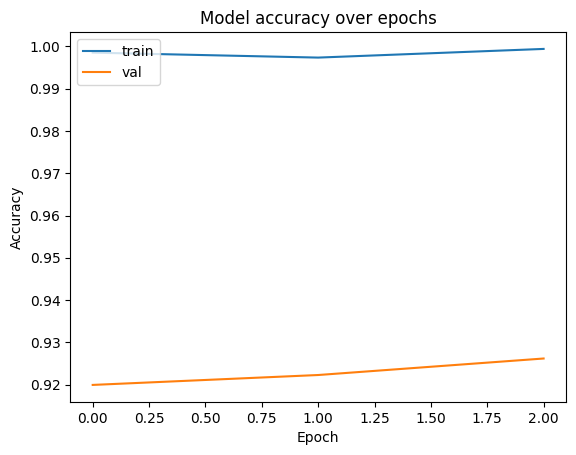

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
nb_batches = len(val_gen)
X_val = np.empty((nb_batches, batch_size, frame_length, 1))
y_val = np.empty((nb_batches, batch_size))

for i in range(nb_batches):
    X_val[i], y_val[i] = val_gen.__getitem__(i)

X_val = X_val.reshape((nb_batches * batch_size, -1))
y_val = y_val.reshape(nb_batches * batch_size)

y_val_actual = np.argmax(sincnet_model.predict(X_val), axis=-1)

80/80 [==============================] - 1s 7ms/step


In [23]:
from sklearn.metrics import precision_recall_fscore_support

# https://en.wikipedia.org/wiki/Precision_and_recall

p, r, f1, _ = precision_recall_fscore_support(y_val,
                                              y_val_actual,
                                              average='macro',
                                              zero_division=0)

print("Precision:", p)
print("Recall:", r)
print("F1 score:", f1)

Precision: 0.9273220057393508
Recall: 0.9270003298010174
F1 score: 0.9262705352963225


(<Figure size 1000x1000 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

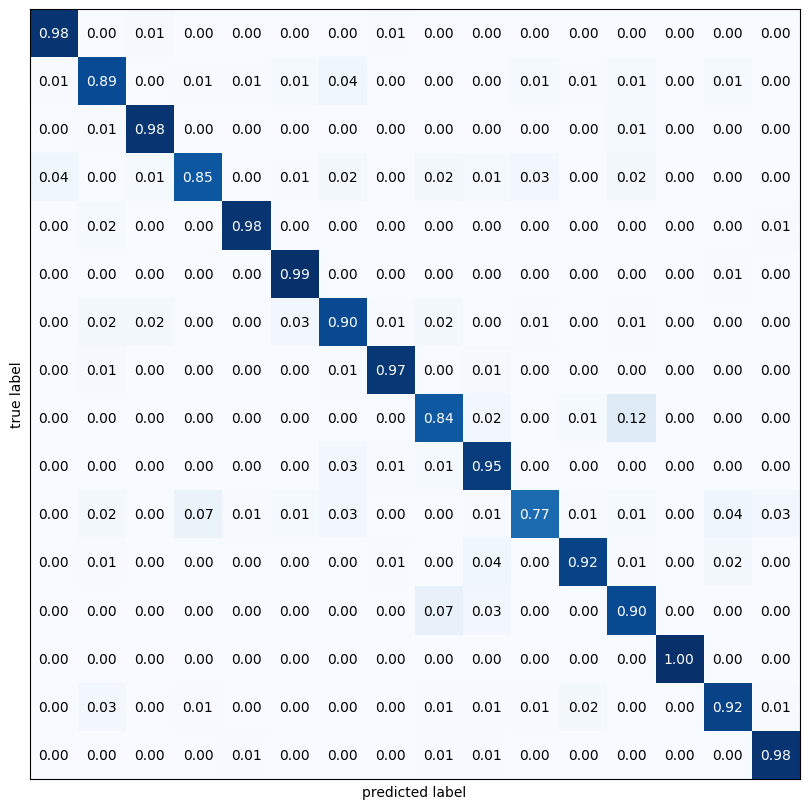

In [24]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_val, y_val_actual)

plot_confusion_matrix(cm,
                      show_normed=True,
                      show_absolute=False,
                      figsize=(10, 10),
                      hide_ticks=True)